# Interpretable Machine Learning

This is the jupyter notebook which creates the graphs from the lecture. We are starting along the same lines. The methods for random forests have been implemented in the script RFintuition_py.

We first install some components needed for the task, which are probably not yet in the environment.

In [ ]:
!pip install treeinterpreter, ipywidgets, pdpbox,

In [3]:
from RFintuition_py import *
from sklearn.externals import joblib
#from resampler import *
import matplotlib.pyplot as plt
import pandas as pd

In this case, I have examined a dataset for german credit risk, which can be obtained from http://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29 .

## Loading and preparing the dataset

In [4]:
df_loan = pd.read_csv("german.data", sep =' ', index_col=False, header=None,
                     names=['StatusChecking', "DurationMonths", "creditHistory",
                            "purpose", "amount", "savingsAccount", "employedSince",
                            "installmentRate","statusSex","otherDebtors","residenceSince",
                            "property","age","otherInstallment","housing","numberCredits",
                            "job","dependentPeople","phone","foreignWorker",'risk'])

In [5]:
value_dict={'A11' : 'less0',
'A12' : '0to200',
'A13' : 'more200',
'A14' : 'nochecking',
'A30' : 'nocredits',
'A31' : 'allcreditspaidduly',
'A32' : 'existingcredit paiddulytillnow',
'A33' : 'delaypayinginpast',
'A34' : 'criticalaccount',
'A40' : 'car(new)',
'A41' : 'car(used)',
'A42' : 'furniture/equipment',
'A43' : 'radio/television',
'A44' : 'domesticappliances',
'A45' : 'repairs',
'A46' : 'education',
'A47' : 'vacation',
'A48' : 'retraining',
'A49' : 'business',
'A410' : 'others',
'A61' : 'less100',
'A62' : '100to500',
'A63' : '500to1000', 
'A64' : 'more1000', 
'A65' : 'unknown',
'A71' : 'unemployed',
'A72' : 'less1year',
'A73' : '1to4years',
'A74' : '4to7years',
'A75' : 'more7years',
'A101' : 'none',
'A102' : 'co-applicant',
'A103' : 'guarantor',
'A121' : 'realestate',
'A122' : 'lifeinsurance',
'A123' : 'carorother',
'A124' : 'noproperty',
'A141' : 'bank',
'A142' : 'stores',
'A143' : 'none',
'A151' : 'rent',
'A152' : 'own',
'A153' : 'free',
'A171' : 'unskilled-non-resident',
'A172' : 'unskilled-resident',
'A173' : 'skilledemployee',
'A174' : 'highlyqualifiedemployee',
'A191' : 'none',
'A192' : 'yes',
'A201' : 'yes',
'A202' : 'no' }

In [6]:
sex_dict={
'A91' : 'male',
'A92' : 'female',
'A93' : 'male',
'A94' : 'male',
'A95' : 'female'}

In [7]:
cat_cols=['StatusChecking','housing','creditHistory','purpose','savingsAccount','employedSince','otherDebtors','property','otherInstallment','job',"phone","foreignWorker",'sex']

In [8]:
df_loan.replace(value_dict,inplace=True)
df_loan['sex']=df_loan['statusSex'].replace(sex_dict)
#df_loan['maritial']=df_loan['StatusSex'].replace(status_dict)
df_loan.drop('statusSex', axis=1, inplace=True)

df_loan_enc=pd.get_dummies(df_loan,columns=cat_cols)


## Train the models for comparison

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from givemetrics import *

In [11]:
df_train, df_test = train_test_split(df_loan_enc)

I suggest to first train a linear model in order to make a point that it is actually worth investing into something, which is harder to interpret

In [12]:
linreg = Pipeline([('scaling', StandardScaler()),
                   ('estimating', LinearRegression())])

In [13]:
linreg.fit(df_train.drop('risk',axis=1),df_train.risk)

print('Training error:', mean_squared_error(df_loan_enc.risk, linreg.predict(df_loan_enc.drop('risk',axis=1))))
print('Test error:', mean_squared_error(df_train.risk, linreg.predict(df_train.drop('risk',axis=1))))

Training error: 0.15670641819600659
Test error: 0.14796442435698232


Then we train a random forest. We want the best model out there. 

In [15]:
rfreg = Pipeline([('scaling', StandardScaler()),
                 ('estimating', RandomForestRegressor())])

In [16]:
rfreg.fit(df_train.drop('risk',axis=1),df_train.risk)

print('Training error:', mean_squared_error(df_loan_enc.risk, rfreg.predict(df_loan_enc.drop('risk',axis=1))))
print('Test error:', mean_squared_error(df_train.risk, rfreg.predict(df_train.drop('risk',axis=1))))

Training error: 0.06604
Test error: 0.031


Finally, is it worth gooing one step further and train a multi-layer perceptron?

In [17]:
nnreg = Pipeline([('scaling', StandardScaler()),
                  ('estimating', MLPRegressor())])

In [18]:
nnreg.fit(df_train.drop('risk',axis=1),df_train.risk)

print('Training error:', mean_squared_error(df_loan_enc.risk, nnreg.predict(df_loan_enc.drop('risk',axis=1))))
print('Test error:', mean_squared_error(df_train.risk, nnreg.predict(df_train.drop('risk',axis=1))))

Training error: 0.07269168361209781
Test error: 0.011284438445981839


Now let's investigate our models. First of all, people always wonder about the feature importance. We give them both in the Gini as well as the Shuffling way. Compare them, spot and explain the differences.

In [32]:
feature_importances = list(zip(df_train.columns, rfreg.named_steps['estimating'].feature_importances_))
feature_importances.sort(key = lambda x:x[1], reverse = True)
print(feature_importances)

[('amount', 0.14392106829628182), ('DurationMonths', 0.10773580012162576), ('age', 0.09531115886090764), ('StatusChecking_more200', 0.08753260849772761), ('installmentRate', 0.03381197867456871), ('residenceSince', 0.02817012831425984), ('savingsAccount_500to1000', 0.024675960034481255), ('property_carorother', 0.02421036314086613), ('creditHistory_existingcredit paiddulytillnow', 0.021428158556556907), ('employedSince_4to7years', 0.019870268342010215), ('otherInstallment_bank', 0.017209339637652414), ('employedSince_less1year', 0.015541780820892803), ('purpose_business', 0.015474897308386493), ('savingsAccount_more1000', 0.015425277343394031), ('property_noproperty', 0.014629579412612012), ('property_realestate', 0.014306099784016724), ('purpose_domesticappliances', 0.01337527354104948), ('otherDebtors_guarantor', 0.013255088446395943), ('job_unskilled-resident', 0.013189995899138381), ('savingsAccount_unknown', 0.012851629512019864), ('property_lifeinsurance', 0.012717069490640697), 

In [33]:
feat_imp(rfreg,df_test.drop('risk',axis=1),df_test.risk)

100%|██████████| 59/59 [00:00<00:00, 268.79it/s]


[('StatusChecking_nochecking', -0.05991999999999997),
 ('DurationMonths', -0.026319999999999982),
 ('employedSince_less1year', -0.007760000000000017),
 ('savingsAccount_less100', -0.005719999999999975),
 ('amount', -0.005040000000000017),
 ('age', -0.004239999999999994),
 ('employedSince_unemployed', -0.0031200000000000117),
 ('otherInstallment_bank', -0.0030799999999999994),
 ('purpose_furniture/equipment', -0.0030000000000000027),
 ('purpose_car(used)', -0.0028800000000000214),
 ('sex_female', -0.002600000000000019),
 ('creditHistory_nocredits', -0.0025600000000000345),
 ('savingsAccount_unknown', -0.0022800000000000042),
 ('property_realestate', -0.0019599999999999895),
 ('employedSince_1to4years', -0.0015600000000000058),
 ('residenceSince', -0.00136),
 ('housing_free', -0.0013199999999999878),
 ('savingsAccount_more1000', -0.0012399999999999911),
 ('purpose_business', -0.0012000000000000066),
 ('otherDebtors_guarantor', -0.0011199999999999821),
 ('job_highlyqualifiedemployee', -0.

Next, we have a look at so called confidence intervals. As this is a per sample number, I give the histograms here. They can be used to investigate the quality of the models. How do you asess it? Investigate some samples from the different classes and see if you understand the differences

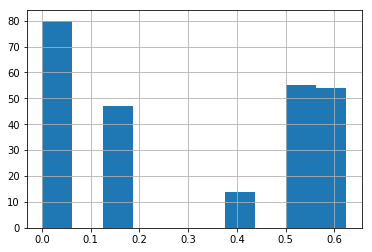

In [35]:
pred_ci(rfreg.named_steps['estimating'], df_test.drop('risk',axis=1),df_test.risk).deviation.hist()

To make the interacting models look like linear models as much as possible, we can use partial dependence plots (PDP). We have selected a few features, which seemed interesting to us. Pick some of your own and see if you find something else/something different.

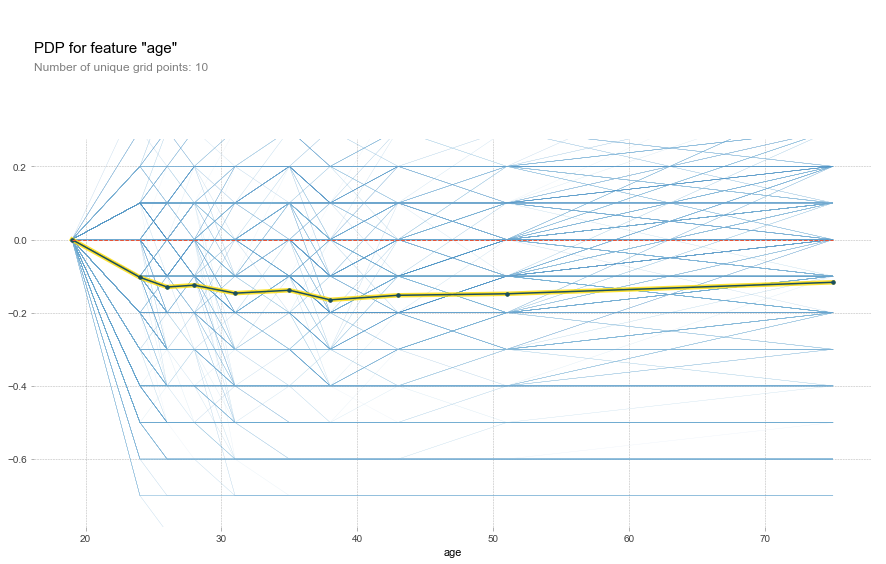

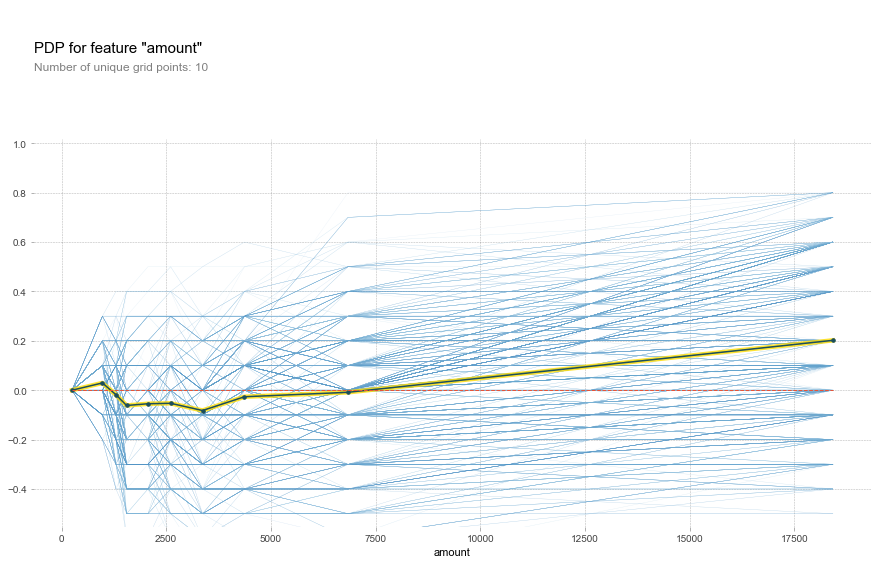

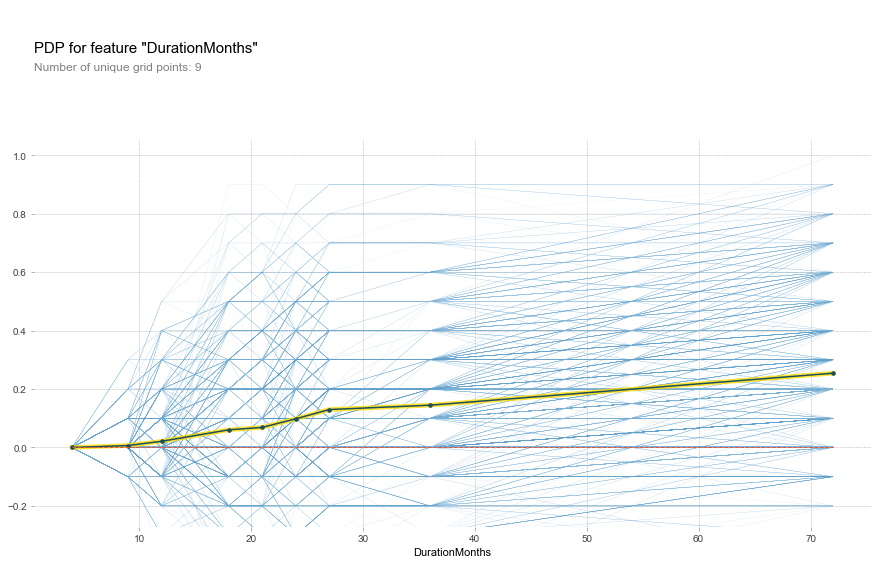

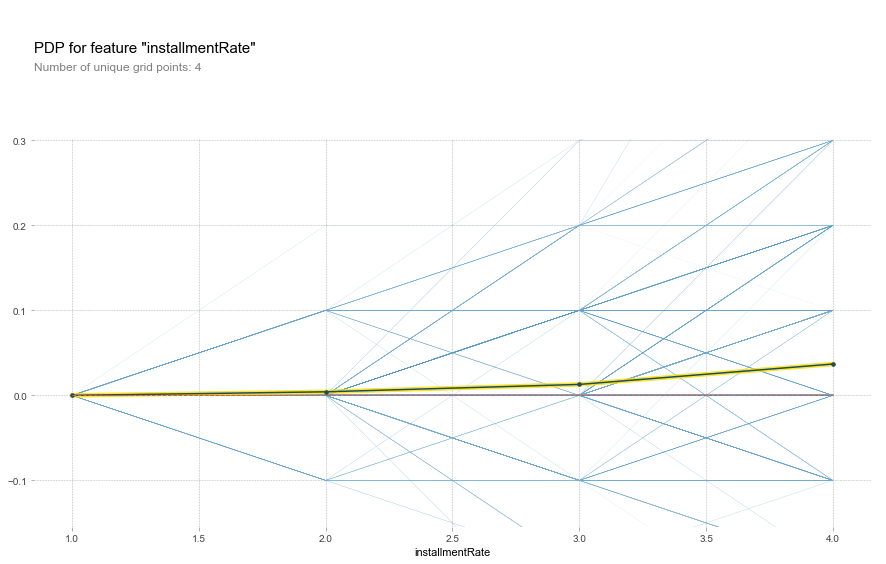

In [36]:
selectfeat = ['age','amount','DurationMonths','installmentRate']

for c in selectfeat: #X_sub.columns:
      plot_pdp(rfreg, df_loan_enc.drop('risk', axis=1),
               feat = c, filename = 'pdp/'+c)

Categorical features can be combined to make pdp-plots

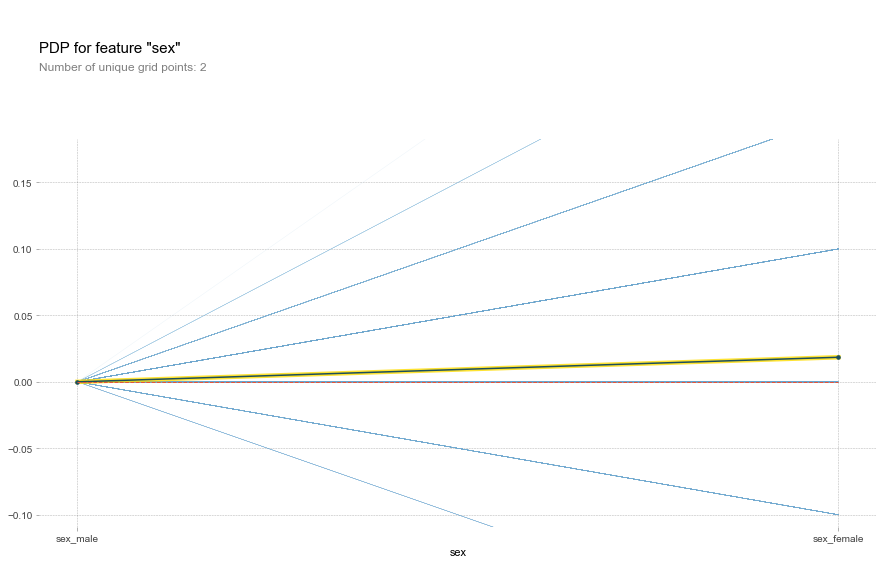

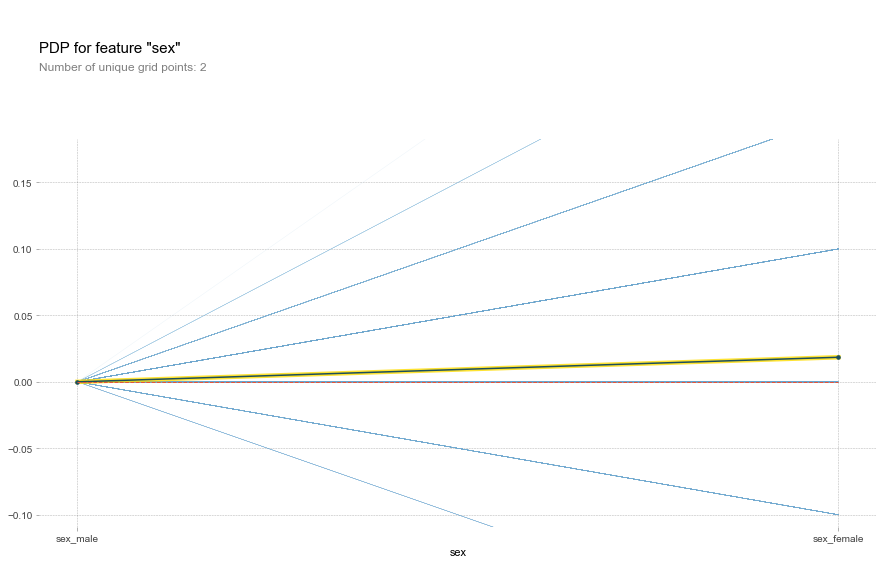

In [43]:
plot_pdp(rfreg, df_loan_enc.drop('risk', axis=1), ['sex_male','sex_female'], feat_name='sex')

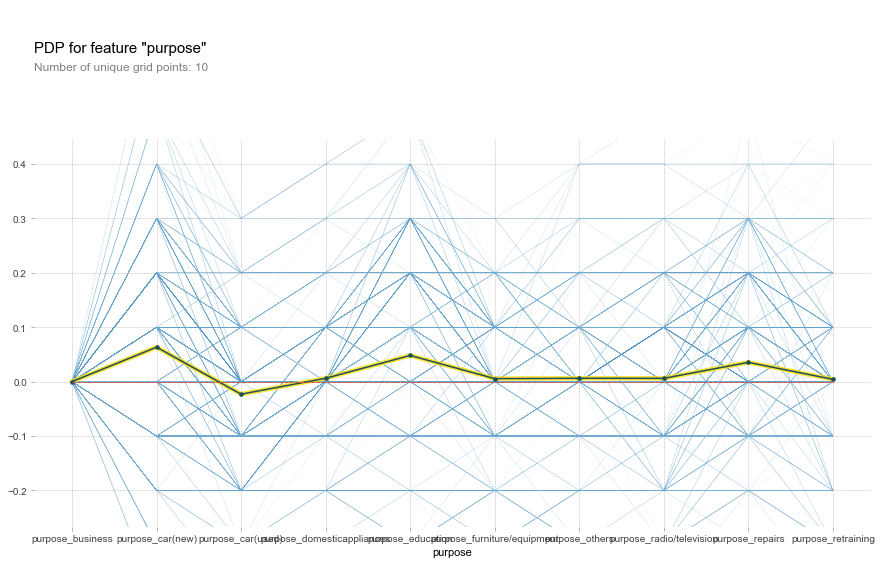

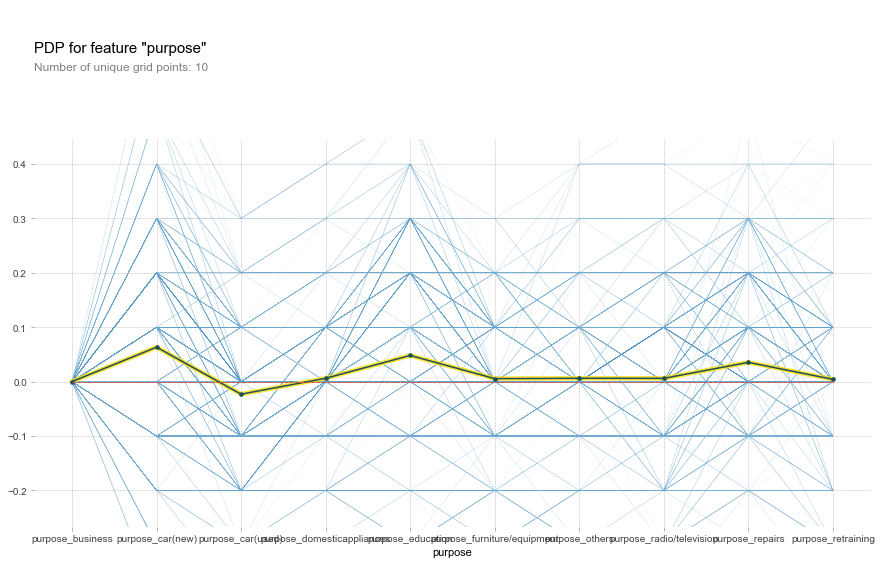

In [44]:
plot_pdp(rfreg, df_loan_enc.drop('risk', axis=1), [ 'purpose_business', 'purpose_car(new)',
       'purpose_car(used)', 'purpose_domesticappliances', 'purpose_education',
       'purpose_furniture/equipment', 'purpose_others',
       'purpose_radio/television', 'purpose_repairs', 'purpose_retraining'],feat_name='purpose')

Now we are analysing the prediction path of a certain sample to be able to see the contribution of each featuer for individual examples

no number and no mustfeats given
[[(array([0.35320294]), 'amount'), (array([-0.16944697]), 'StatusChecking_nochecking'), (array([-0.10513012]), 'otherInstallment_none'), (array([0.05238095]), 'employedSince_1to4years'), (array([0.04805551]), 'DurationMonths'), (array([0.04285714]), 'installmentRate'), (array([-0.04003747]), 'age'), (array([0.02571802]), 'Andere')]]
no number and no mustfeats given
[[(array([0.35320294]), 'amount'), (array([-0.16944697]), 'StatusChecking_nochecking'), (array([-0.10513012]), 'otherInstallment_none'), (array([0.05238095]), 'employedSince_1to4years'), (array([0.04805551]), 'DurationMonths'), (array([0.04285714]), 'installmentRate'), (array([-0.04003747]), 'age'), (array([0.02571802]), 'Andere')], [(array([0.35320294]), 'amount'), (array([-0.16944697]), 'StatusChecking_nochecking'), (array([-0.10513012]), 'otherInstallment_none'), (array([0.05238095]), 'employedSince_1to4years'), (array([0.04805551]), 'DurationMonths'), (array([0.04285714]), 'installmentRat

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

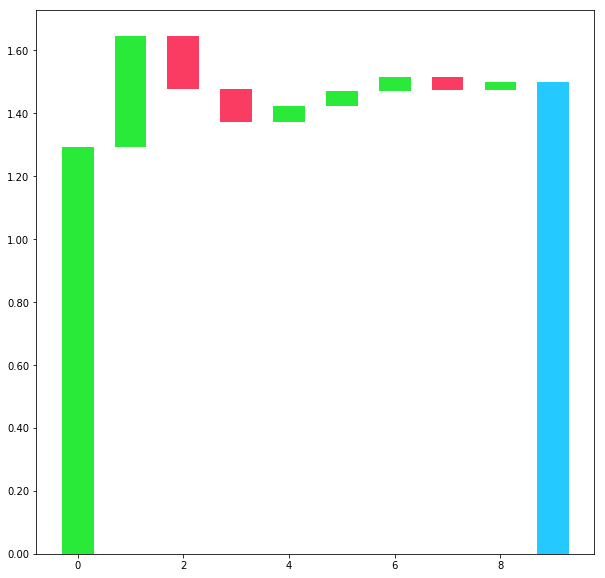

In [37]:
pred_path(rfreg.named_steps['estimating'], df_loan_enc.drop('risk',axis=1).columns, df_test.drop('risk',axis=1).iloc[0:10,:], cl=None)

## Shap Values

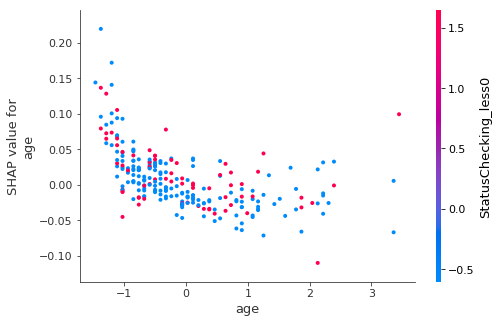

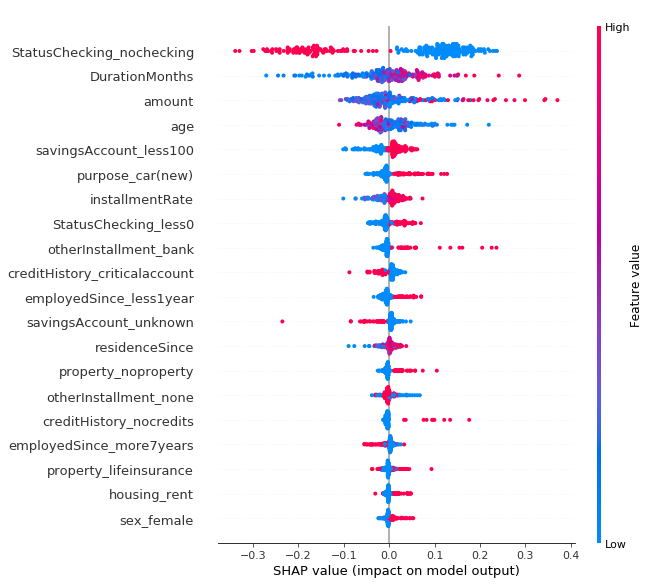

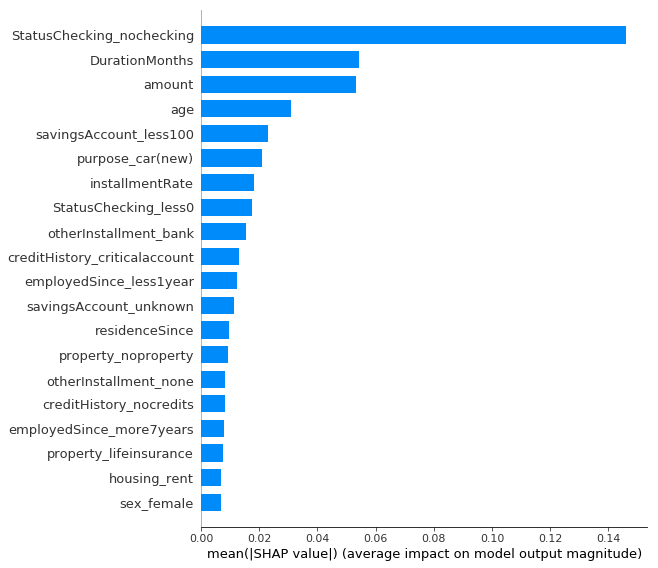

In [46]:
import shap
shap.initjs()
#trans_cols = [c for c, i in zip(X_sub.columns,rfreg.named_steps['estimating'].get_support()) if i]
X_trans = pd.DataFrame(rfreg.named_steps['scaling'].transform(df_test.drop('risk',axis=1)), columns = df_test.drop('risk',axis=1).columns)
explainer = shap.TreeExplainer(rfreg.named_steps['estimating'])
shap_values = explainer.shap_values(X_trans)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_trans.iloc[0,:])
shap.force_plot(explainer.expected_value, shap_values[1,:], X_trans.iloc[1,:])
shap.force_plot(explainer.expected_value, shap_values, X_trans)
shap.dependence_plot('age', shap_values, X_trans)
shap.summary_plot(shap_values, X_trans)
shap.summary_plot(shap_values, X_trans, plot_type='bar')

In [49]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_trans.iloc[0,:])

In [50]:
shap.force_plot(explainer.expected_value, shap_values[1,:], X_trans.iloc[1,:])

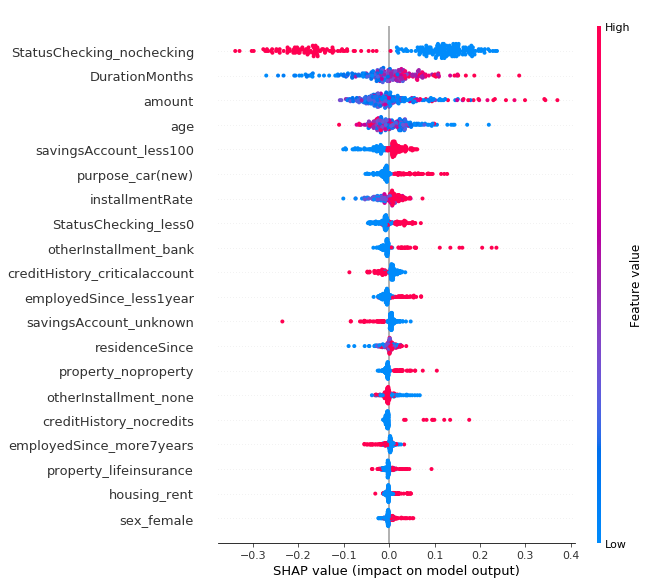

In [47]:
shap.summary_plot(shap_values, X_trans)

Explore the different representations and try to regain the insights from PDP-Plots, Feature importances etc.

In [48]:
shap.force_plot(explainer.expected_value, shap_values, X_trans)

## Lime

In [59]:
import lime
import lime.lime_tabular

lime_explainer = lime.lime_tabular.LimeTabularExplainer(df_train.drop('risk',axis=1).values, feature_names=df_train.drop('risk',axis=1).columns.values.tolist(), class_names=['risk'], categorical_features=None, verbose=True, mode='regression')

exp = lime_explainer.explain_instance(df_test.drop('risk',axis=1).values[35], rfreg.predict, num_features=5)
exp.show_in_notebook(show_table=True)

Intercept 1.4054532424859045
Prediction_local [1.35149609]
Right: 1.6


## Exercises

1. Try to analyze with Shap (or Lime) why MNIST/Fashion-MNIST is classified into different categories.
2. Make the predictions of your dataset transparent and interpretable with the above methods. Try different algorithms. Do you see differences, which worry you?